In [182]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

In [183]:
import nltk
from nltk.corpus import stopwords

import language_tool_python
from textblob import TextBlob

from tqdm.notebook import tqdm

In [184]:
import keras

from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [642]:
def display_training_curves(history): #this function will be useful for model evaulation
    fig, ax = plt.subplots(ncols=1, nrows=2,figsize=(7,10))
    ax[0].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[0].scatter(y=history.history['accuracy'],x=range(0,len(history.history['accuracy'])), label='training accuracy')
    ax[0].legend()
    ax[0].title.set_text('Training and Validation Accuracy')
    #ax[0].set_xlabel('number of epochs')
    #ax[0].set_ylim(0,max(history.history['binary_accuracy']))
    
    ax[1].plot(history.history['val_loss'], label='validation loss')
    ax[1].scatter(y=history.history['loss'],x=range(0,len(history.history['loss'])), label='training loss')
    ax[1].title.set_text('Training and Validation loss')
    ax[1].legend()
    ax[1].set_xlabel('number of epochs')
    #ax[1].set_ylim(0)

In [186]:
#check paths of the datasets
import os
for dirname, _, filenames in os.walk('/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/sentiment_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/sentiment_data/.DS_Store
/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/sentiment_data/Corona_NLP_train.csv
/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/sentiment_data/Corona_NLP_test.csv


In [187]:
df_train = pd.read_csv("/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/sentiment_data/Corona_NLP_train.csv", encoding = 'latin1')

df_test = pd.read_csv("/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/sentiment_data/Corona_NLP_test.csv", encoding = 'latin1')

df_train.head()



,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [188]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


We won't need Username, ScreenName, TweetAt and Location columns

In [189]:
df_test.drop(['UserName', 'ScreenName', 'TweetAt', 'Location'], axis=1, inplace=True)
df_train.drop(['UserName', 'ScreenName', 'TweetAt', 'Location'], axis=1, inplace=True)

In [193]:
df = df_train.append(df_test).reset_index(drop=True)
df.shape

(44955, 2)

Check for any NULL values in the dataset

In [191]:
print("null values:\n", df.isnull().any())

null values:
 OriginalTweet    False
Sentiment        False
dtype: bool


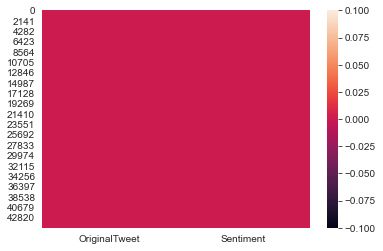

In [194]:
sns.heatmap(df.isnull())

Create a new column for tweet processing

In [195]:
df['processed_tweet'] = df['OriginalTweet']
df.head(2)

,OriginalTweet,Sentiment,processed_tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...


Create a WordCloud before processing

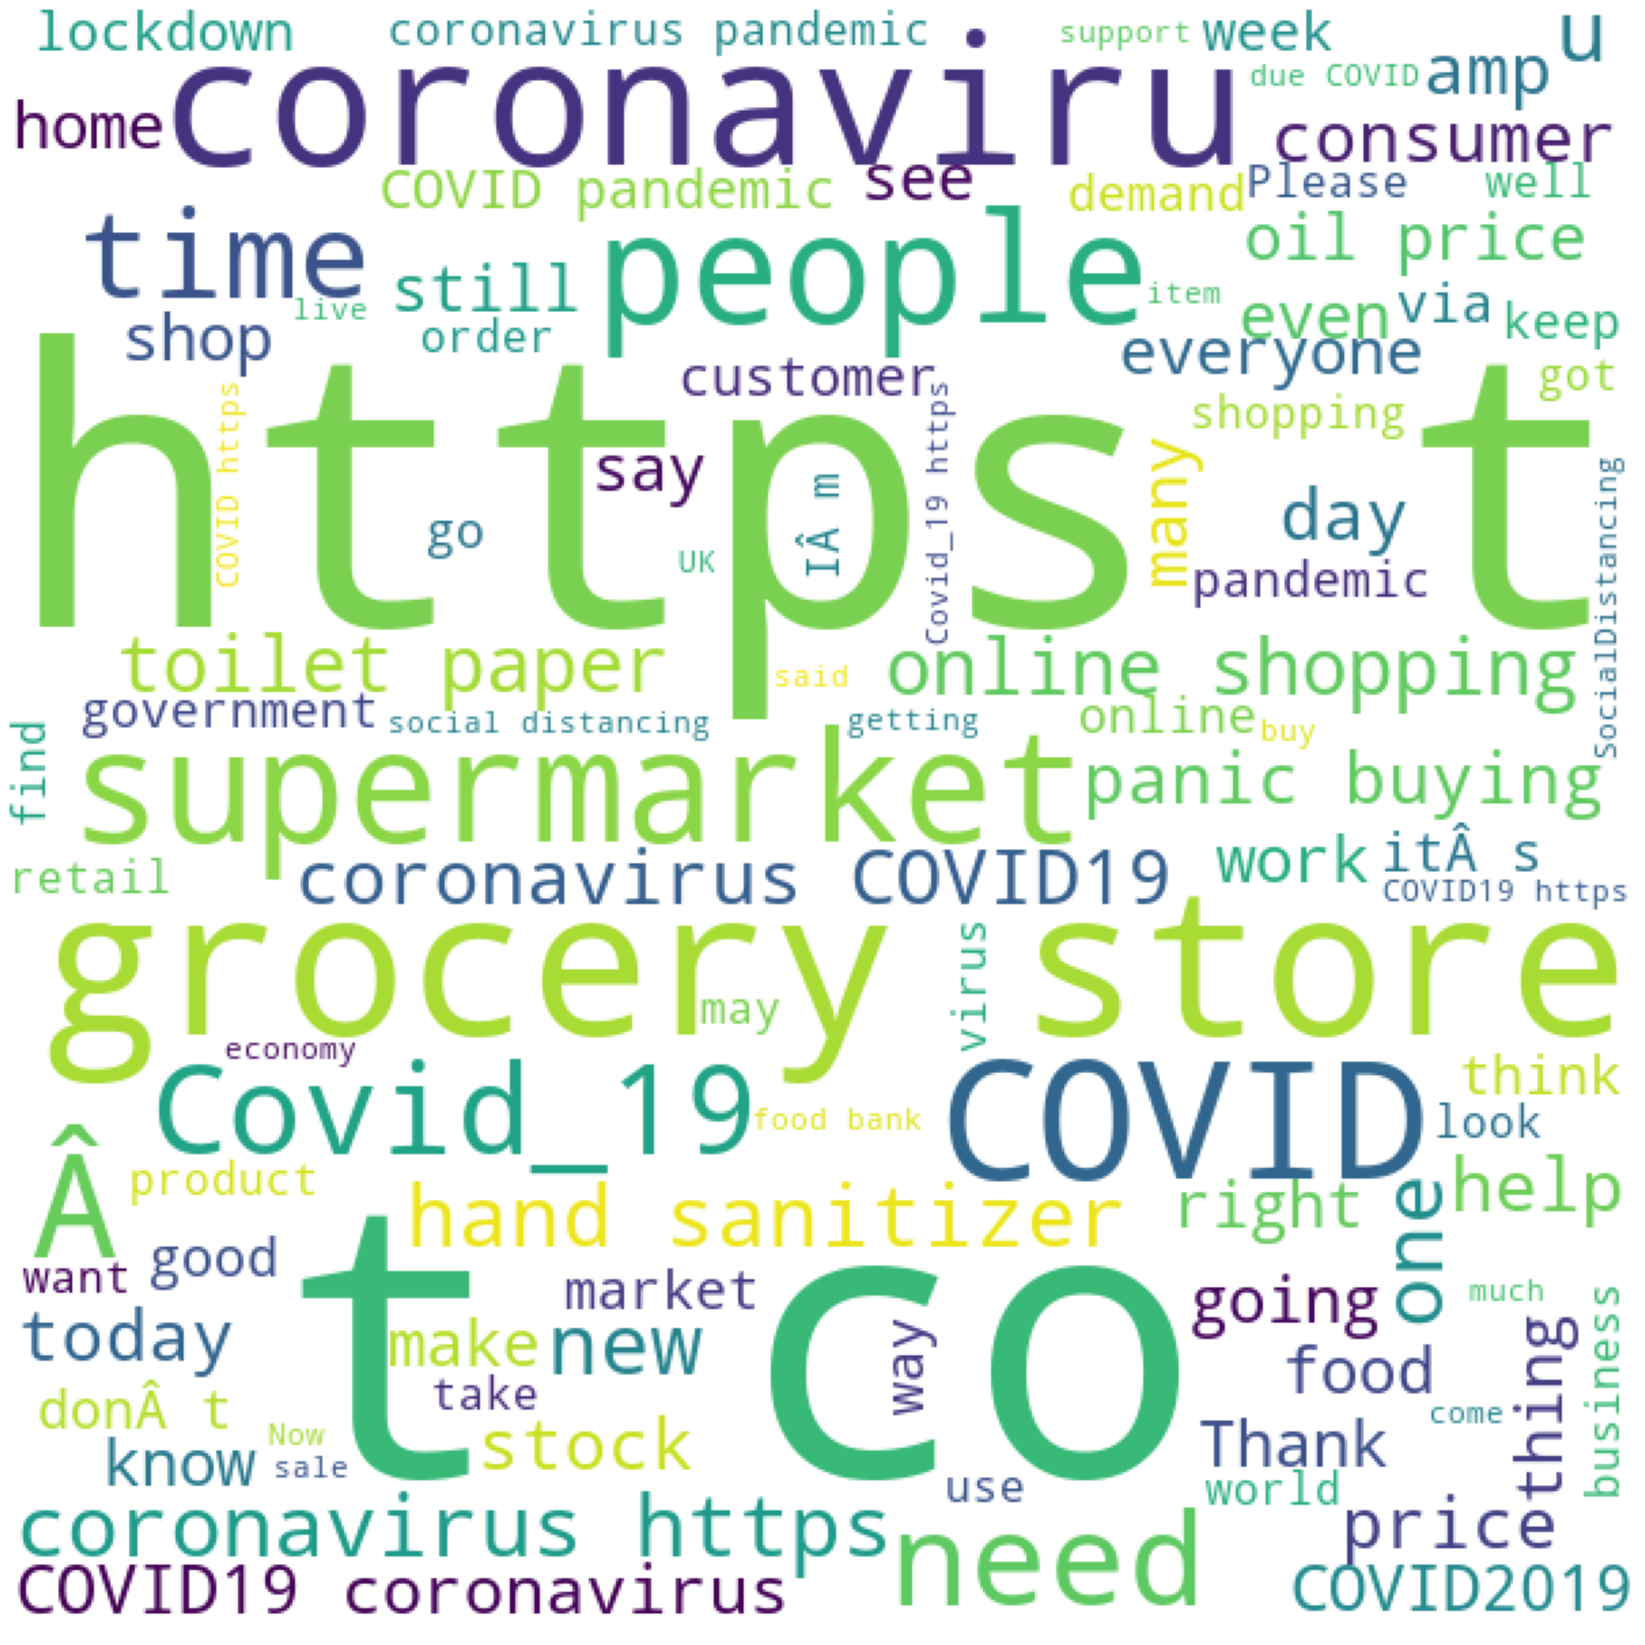

In [196]:
from wordcloud import WordCloud
from twokenize import tokenizeRawTweetText as twokenize

stop_words = list(stopwords.words("english"))

one_text = ("")

for item in list(df.processed_tweet):
    one_text += (item)
    one_text += ("\n")

words_tokens = twokenize(one_text)

filtered_text = [w for w in words_tokens if not w in stop_words]
wl_space_split = " ".join(filtered_text)
word_cloud_1 = WordCloud(max_words=100, width=600, height=600, background_color='white').generate(wl_space_split)


plt.figure(figsize=(30,30))
plt.imshow(word_cloud_1)
plt.axis("off")
plt.show()

Let's investigate hashtags

In [197]:
def find_hashtags(tweet):
    hashtags = re.findall(r'#\w+', tweet)
    return hashtags

In [198]:
df['hashtags'] = df.OriginalTweet.apply(find_hashtags)

In [199]:
hashtags = df['hashtags'].to_list()

In [200]:
hashtags_all = []

for lst in hashtags:
    for i in lst:
        hashtags_all.append(i)

In [201]:
df_hashtags = pd.DataFrame(hashtags_all, columns=["hashtag"])

df_hashtags["count"] = 1

df_hashtags.groupby("hashtag").count().sort_values(by='count', ascending=False).head()

,count
hashtag,
#coronavirus,14050
#Covid_19,4041
#COVID19,3622
#Coronavirus,2511
#COVID2019,1809


In [233]:
df_hashtags.groupby("hashtag").count().sort_values(by='count', ascending=False).loc[df_hashtags.groupby("hashtag").count().sort_values(by='count', ascending=False)["count"] > 300,:]

,count
hashtag,
#coronavirus,14050
#Covid_19,4041
#COVID19,3622
#Coronavirus,2511
#COVID2019,1809
#toiletpaper,1452
#COVID,1430
#covid19,1162
#CoronaCrisis,735


In [203]:
del df['hashtags']

<strong>Checking the distribution of labels in all of the datasets</strong>

,OriginalTweet,processed_tweet
Sentiment,,
Extremely Negative,6073,6073
Extremely Positive,7223,7223
Negative,10958,10958
Neutral,8332,8332
Positive,12369,12369


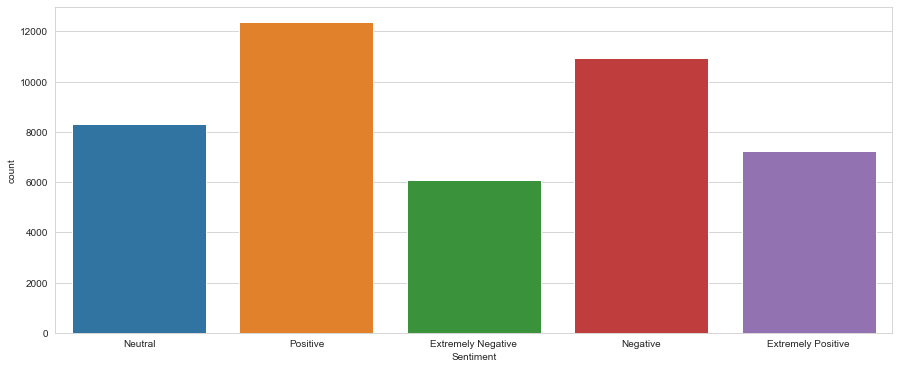

In [204]:
#check the distribution of the labels:

plt.figure(figsize=(15,6))

sns.set_style("whitegrid")

sns.countplot(df['Sentiment'])

df.groupby('Sentiment').count().iloc[:,0:2]

<strong>Some more of Data Processing</strong><br>

Remove mentions from tweets

In [205]:
def remove_mentions(text):
    text = re.sub(r'@\w+',' ',text)
    return text

In [206]:
df['processed_tweet'] = df['processed_tweet'].apply(remove_mentions)

Now, it's time for URLs

In [207]:

def del_url(text):
    x = re.sub(r'http\S+', "",text)
    return x
    

In [208]:
df['processed_tweet'] = df['processed_tweet'].apply(del_url)

Correct spelling and grammar

In [210]:
tool = language_tool_python.LanguageTool('en-US')
mistakes = 0

def correct_grammar(text):
    text = tool.correct(text)
    global mistakes 
    mistakes += len(tool.check(text))
    return text

In [211]:
df['processed_tweet'] = tqdm(df['processed_tweet'].apply(correct_grammar))

In [212]:
mistakes

24623

In [213]:
df.head()

,OriginalTweet,Sentiment,processed_tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,And and
1,advice Talk to your neighbours family to excha...,Positive,Advice Talk to your neighbors family to exchan...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the #COV..."


In [144]:
def correct_grammar_fast(text):
    text = tool.correct(text)
    return(text)

In [147]:
correct_grammar_fast = lambda x: tool.correct(x)

In [151]:
for row in tqdm(range(0, 44955)):
    df.loc[row, "processed_tweet"] = correct_grammar_fast(df.loc[row, "processed_tweet"])

In [215]:
df.to_csv("tweets_grammar_corrected.csv") 
#save the corrected tweets, since it is computationally demanding operation

In [216]:
df_checkpoint = df.copy() #get a checkpoint dataframe

In [217]:
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Removing punctuation

In [218]:
def remove_punctuations(text):
    text = "".join([punc for punc in text if not punc in punctuation])
    return text

In [219]:
df['processed_tweet'] = df['processed_tweet'].apply(remove_punctuations)

Lowering the text of all tweets:

In [220]:
df['processed_tweet'] = df['processed_tweet'].apply(lambda x: x.lower())

Removing the stopwords (as they may not be useful in case of our predictions)

In [221]:
stop_words = stopwords.words("English")
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [222]:
def remove_stopwords(text):
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    return text

In [223]:
df['processed_tweet']=df['processed_tweet'].apply(remove_stopwords)

In [225]:
df.sample(10)

,OriginalTweet,Sentiment,processed_tweet
8520,No one:\r\r\n\r\r\nPeople at the grocery store...,Negative,one people grocery store coronavirus nsfwtwitt...
13568,"If COVID-19 doesnÂt kill me, online shopping ...",Negative,covid19 dominant kill online shopping quaranti...
6731,Truckers are trying to navigate growing challe...,Positive,truckers trying navigate growing challenges hi...
15150,Purell Hand Sanitizer\r\r\n\r\r\nhttps://t.co/...,Positive,purely hand sanitizer coronavirus supplies res...
743,IÂm preparing to self isolate for 12 weeks. \...,Positive,iam preparing selfisolate 12 weeks worldfamous...
10352,So pasta for lunch. And not because it's the o...,Extremely Positive,pasta lunch thing cupboard glad dont eat every...
29492,#RecipeOfTheDay is particularly for American f...,Extremely Positive,recipeoftheday particularly american friends k...
8340,@katjanechild ThatÂs not in keeping with the ...,Neutral,tatars keeping cpa views consumer goods camp s...
10693,ÂFinns are volunteering in large numbers to g...,Negative,finns volunteering large numbers go grocery st...
31485,"@ScottMorrisonMP dear prime minister , nrma ha...",Extremely Positive,dear prime minister nra also increased prices ...


In [226]:
#save preprocessed tweets
df.to_csv("SentimentTweets_processed.csv")

Let's look for blank post-processing tweets

In [241]:
df.loc[df['processed_tweet'] =="",:].reset_index()['index'].to_list()

[0,
 186,
 583,
 2190,
 5946,
 13777,
 13843,
 14840,
 16924,
 18437,
 22994,
 28549,
 28987,
 29888,
 30345,
 30473,
 31293,
 31440,
 31627,
 31657,
 32455,
 34871,
 35563,
 35565,
 36781,
 37646,
 44223,
 44352]

In [242]:
df = df.drop(df.loc[df['processed_tweet'] =="",:].reset_index()['index'].to_list(), axis=0)

<strong> Now, it's time to decode the labels</strong>
<br><br>Should we leave 5 labels, or convert them into just 3 (Negative, Neutral, Positive)?

In [558]:
#let's try with 5 labels encoded into interval from -1 to 1

def decode_label(label):
    global dec_label
    if label == "Extremely Negative":
        dec_label = 0
    elif label == "Negative":
        dec_label = 1
    elif label == "Neutral":
        dec_label = 2
    elif label == "Positive":
        dec_label = 3
    elif label == "Extremely Positive":
        dec_label = 4
    return dec_label

In [559]:
df['sentiment_dec'] = df.Sentiment.apply(decode_label)

In [561]:
df.head(10)

,OriginalTweet,Sentiment,processed_tweet,sentiment_dec
0,advice Talk to your neighbours family to excha...,Positive,advice talk neighbors family exchange phone nu...,3
1,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,3
2,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,3
3,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid19 outbreak im paran...,0
4,As news of the regionÂs first confirmed COVID...,Positive,news regionals first confirmed covid19 case ca...,3
5,Cashier at grocery store was sharing his insig...,Positive,cashier grocery store sharing insights covid19...,3
6,Was at the supermarket today. Didn't buy toile...,Neutral,supermarket today didnt buy toilet paper rebel...,2
7,Due to COVID-19 our retail store and classroom...,Positive,due covid19 retail store classroom atlanta ope...,3
8,"For corona prevention,we should stop to buy th...",Negative,corona prevention stop buy things cash use onl...,1
9,All month there hasn't been crowding in the su...,Neutral,month hasnt crowding supermarkets restaurants ...,2


In [562]:
df.sentiment_dec.unique()

array([3, 0, 2, 1, 4])

In [314]:
df.to_csv("Sentiment_tweets_processed.csv")

In [315]:
df_check = pd.read_csv("Sentiment_tweets_processed.csv", index_col='Unnamed: 0')
df_check.head()

,OriginalTweet,Sentiment,processed_tweet,sentiment_dec
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbors family exchange phone nu...,3.0
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,3.0
3,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,3.0
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid19 outbreak im paran...,0.0
5,As news of the regionÂs first confirmed COVID...,Positive,news regionals first confirmed covid19 case ca...,3.0


<strong>Let's investigate length of our processed tweets</strong>

In [316]:
def word_count(text):
    to_words = text.split(" ")
    count = len(to_words)
    return count

In [317]:
df['word_count'] = df['processed_tweet'].apply(word_count)

In [318]:
df['word_count'].max()

49

In [319]:
del df['word_count']

<strong>Tokenizing and padding our processed tweets</strong>

In [566]:
df['processed_tweet'] = df['processed_tweet'].astype('str')

In [567]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(df.processed_tweet)

In [663]:
import pickle

#saving the tokenizer
with open('sentiment_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [568]:
#check the number of unique tokens

tokens_num = len(tokenizer.word_index) + 1

print(f"found {tokens_num} unique tokens") # print the number of detected tokens

found 46605 unique tokens


In [570]:
sequences_tweets = tokenizer.texts_to_sequences(df['processed_tweet'].values)

In [571]:
maxlen = 49

x_train, x_test, y_train, y_test = train_test_split(sequences_tweets, df['sentiment_dec'].values, test_size=0.3)

x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post')

In [324]:
x_train.shape

(31448, 49)

<strong>We will also need a function for processing individual tweets before making predictions</strong>

In [325]:
def process_single_tweet(text, tokenizer):
    to_process = text
    
    to_process = del_url(to_process) #remove any URLs starting with HTTPS
    to_process = remove_mentions(to_process) #remove any @mentions
    
    to_process = correct_grammar(to_process) #correct grammar mistakes
    to_process = remove_punctuations(to_process) #remove punctuation
    
    to_process = to_process.lower() #lower text
    to_process = remove_stopwords(to_process) #remove all stopwords
    
    to_process = tokenizer.texts_to_sequences([to_process])[0] #tokenize the text with the tokenizer trained on our data
    to_process = pad_sequences([to_process], maxlen=maxlen, padding='post')
    
    return to_process

<strong>Once we have prepared everything, let's move to ML model creation</strong>

In [326]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Bidirectional, SimpleRNN, GRU, LSTM, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras import metrics

from sklearn.metrics import classification_report

In [327]:
from keras import regularizers
from keras.callbacks import EarlyStopping

In [341]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

In [342]:
early_stop = EarlyStopping(patience=3, verbose=1, min_delta=0.0001,restore_best_weights=True)

In [346]:
del model1

In [347]:
model1 = Sequential()

model1.add(Embedding(input_dim=tokens_num, output_dim=16, input_length=maxlen))
model1.add(Flatten())

model1.add(Dense(5, activation = 'softmax'))

model1.compile(loss="categorical_crossentropy" ,optimizer='adam' ,metrics=['acc'])

model1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 49, 16)            745728    
_________________________________________________________________
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 3925      
Total params: 749,653
Trainable params: 749,653
Non-trainable params: 0
_________________________________________________________________


In [348]:
history1 = model1.fit(x_test, y_test,
                     epochs=30,
                     batch_size=32,
                     validation_split=0.2,
                     callbacks=[early_stop])

Epoch 1/30
337/337 [==============================] - 1s 3ms/step - loss: 1.5585 - acc: 0.2760 - val_loss: 1.4814 - val_acc: 0.3175
Epoch 2/30
337/337 [==============================] - 1s 2ms/step - loss: 1.3637 - acc: 0.4439 - val_loss: 1.3105 - val_acc: 0.4451
Epoch 3/30
337/337 [==============================] - 1s 2ms/step - loss: 0.9740 - acc: 0.7346 - val_loss: 1.2138 - val_acc: 0.4874
Epoch 4/30
337/337 [==============================] - 1s 2ms/step - loss: 0.6192 - acc: 0.8742 - val_loss: 1.1905 - val_acc: 0.4996
Epoch 5/30
337/337 [==============================] - 1s 3ms/step - loss: 0.3767 - acc: 0.9421 - val_loss: 1.2024 - val_acc: 0.4993
Epoch 6/30
337/337 [==============================] - 1s 2ms/step - loss: 0.2276 - acc: 0.9781 - val_loss: 1.2317 - val_acc: 0.4930
Epoch 7/30
337/337 [==============================] - 1s 2ms/step - loss: 0.1466 - acc: 0.9874 - val_loss: 1.2688 - val_acc: 0.4855
Restoring model weights from the end of the best epoch.
Epoch 00007: early s

In [349]:
model1.evaluate(x_test, y_test)

422/422 [==============================] - 0s 596us/step - loss: 0.5524 - acc: 0.8567


[0.5523892641067505, 0.8567401170730591]

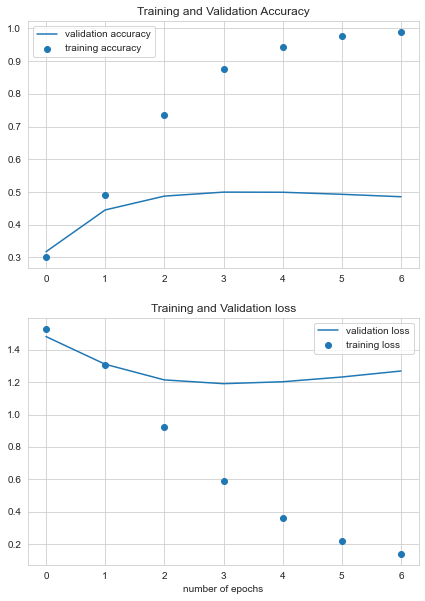

In [350]:
display_training_curves(history1)

<strong>Since classification of 5 labels did not go well, ;et's do the same for 3 labels</strong>

In [602]:
df.sample(20)

,OriginalTweet,Sentiment,processed_tweet,sentiment_dec
43263,SUPERMARKET IN BARCELONA | SAKURAÂS innocent ...,Positive,supermarket barcelona saturdays innocent react...,2
38997,Toilet roll cakes keep Finnish baker in busine...,Neutral,toilet roll cakes keep finnish baker business 19,1
26417,Important tips for safe online shopping post C...,Positive,important tips safe online shopping post covid...,2
17348,Still hunting for #handsanitizer? CBD hand san...,Positive,still hunting hand sanitizer cbd hand sanitize...,2
533,"Hey, @AldiUSA - the employees in Aldi and Trad...",Extremely Negative,hey — employees aldi trader joes stores deserv...,0
41629,"U.S. World Food Prices Fell During February: ""...",Negative,us world food prices fell february “world food...,0
34531,Your daily recap coming up on right now,Neutral,daily recap coming right,1
27470,Check out the recent @FTC blog post. Here are ...,Positive,check recent blog post things need know relief...,2
8039,"...after a disappointing 3 days, you finally m...",Negative,disappointing 3 days finally manage get eggs t...,0
26729,"If there is anything COVID-19 has taught me, i...",Negative,anything covid19 taught itas coping mechanisms...,0


In [603]:
sequences_tweets = tokenizer.texts_to_sequences(df['processed_tweet'].values)

In [604]:
def decode_into_three(label):
    global dec_label
    if label == "Extremely Negative":
        dec_label = 0
    elif label == "Negative":
        dec_label = 0
    elif label == "Neutral":
        dec_label = 1
    elif label == "Positive":
        dec_label = 2
    elif label == "Extremely Positive":
        dec_label = 2
    return dec_label

In [605]:
df['sentiment_dec'] = df['Sentiment'].apply(decode_into_three)

In [606]:
maxlen = 49

x_train, x_test, y_train, y_test = train_test_split(sequences_tweets, df['sentiment_dec'].values, test_size=0.3)

x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post')

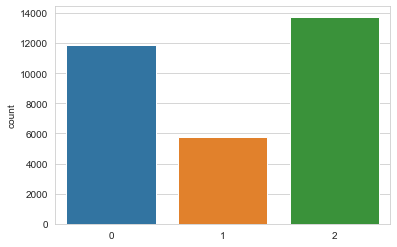

In [607]:
sns.countplot(y_train)

In [608]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [644]:
def display_training_curves(history): #this function will be useful for model evaulation
    fig, ax = plt.subplots(ncols=1, nrows=2,figsize=(7,10))
    ax[0].plot(history.history['val_acc'], label='validation accuracy')
    ax[0].scatter(y=history.history['acc'],x=range(0,len(history.history['acc'])), label='training accuracy')
    ax[0].legend()
    ax[0].title.set_text('Training and Validation Accuracy')
    #ax[0].set_xlabel('number of epochs')
    #ax[0].set_ylim(0,max(history.history['binary_accuracy']))
    
    ax[1].plot(history.history['val_loss'], label='validation loss')
    ax[1].scatter(y=history.history['loss'],x=range(0,len(history.history['loss'])), label='training loss')
    ax[1].title.set_text('Training and Validation loss')
    ax[1].legend()
    ax[1].set_xlabel('number of epochs')
    #ax[1].set_ylim(0)

In [645]:
del model2

In [646]:
model2 = Sequential()

model2.add(Embedding(input_dim=tokens_num, output_dim=16, input_length=maxlen))
model2.add(Flatten())

model2.add(Dense(3, activation = 'softmax'))

model2.compile(loss="categorical_crossentropy" ,optimizer='adam' ,metrics=['acc'])

model2.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 49, 16)            745680    
_________________________________________________________________
flatten_20 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 3)                 2355      
Total params: 748,035
Trainable params: 748,035
Non-trainable params: 0
_________________________________________________________________


In [647]:
history2 = model2.fit(x_test, y_test,
                     epochs=30,
                     batch_size=32,
                     validation_split=0.2,
                     callbacks=[early_stop])

Epoch 1/30
337/337 [==============================] - 1s 3ms/step - loss: 1.0376 - acc: 0.4239 - val_loss: 0.9577 - val_acc: 0.5701
Epoch 2/30
337/337 [==============================] - 1s 2ms/step - loss: 0.8231 - acc: 0.6860 - val_loss: 0.8042 - val_acc: 0.6439
Epoch 3/30
337/337 [==============================] - 1s 2ms/step - loss: 0.4922 - acc: 0.8571 - val_loss: 0.7457 - val_acc: 0.6751
Epoch 4/30
337/337 [==============================] - 1s 2ms/step - loss: 0.2815 - acc: 0.9400 - val_loss: 0.7431 - val_acc: 0.6866
Epoch 5/30
337/337 [==============================] - 1s 2ms/step - loss: 0.1636 - acc: 0.9731 - val_loss: 0.7578 - val_acc: 0.6858
Epoch 6/30
337/337 [==============================] - 1s 2ms/step - loss: 0.0967 - acc: 0.9893 - val_loss: 0.7866 - val_acc: 0.6843
Epoch 7/30
337/337 [==============================] - 1s 2ms/step - loss: 0.0609 - acc: 0.9961 - val_loss: 0.8160 - val_acc: 0.6818
Epoch 8/30
337/337 [==============================] - 1s 2ms/step - loss: 0.

In [648]:
model2.evaluate(x_test, y_test)

422/422 [==============================] - 0s 562us/step - loss: 0.2825 - acc: 0.9179


[0.28247198462486267, 0.9178722500801086]

In [665]:
from keras.models import save_model

In [667]:
model2.save("sentiment_model.h5", save_format='h5')

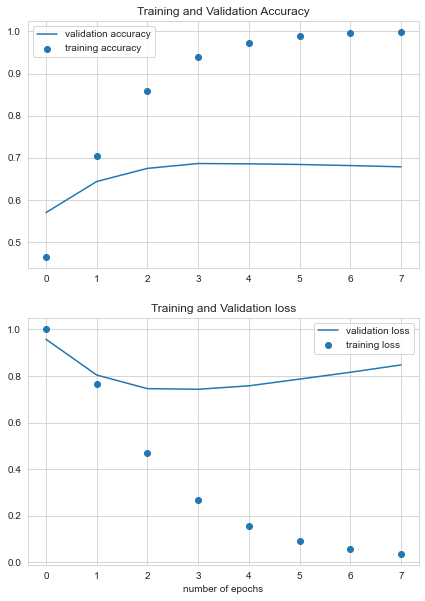

In [649]:
display_training_curves(history2)

In [613]:
model3 = Sequential()

model3.add(Embedding(input_dim=tokens_num, output_dim=16, input_length=maxlen))

model3.add(Bidirectional(GRU(256, return_sequences=True)))
model3.add(GlobalAveragePooling1D())

model3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model3.add(Dropout(0.25))

model3.add(Dense(3, activation = 'softmax'))

model3.compile(loss="categorical_crossentropy" ,optimizer='adam' ,metrics=['acc'])

model3.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 49, 16)            745680    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 49, 512)           420864    
_________________________________________________________________
global_average_pooling1d_9 ( (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 3)                 195       
Total params: 1,199,571
Trainable params: 1,199,571
Non-trainable params: 0
___________________________________________

In [615]:
history3 = model3.fit(x_test, y_test,
                     epochs=30,
                     batch_size=32,
                     validation_split=0.2,
                     callbacks=[early_stop])

Epoch 1/30
337/337 [==============================] - 29s 78ms/step - loss: 1.0814 - acc: 0.4385 - val_loss: 0.9105 - val_acc: 0.5553
Epoch 2/30
337/337 [==============================] - 25s 73ms/step - loss: 0.8138 - acc: 0.6327 - val_loss: 0.8274 - val_acc: 0.6614
Epoch 3/30
337/337 [==============================] - 24s 73ms/step - loss: 0.5014 - acc: 0.8291 - val_loss: 0.7658 - val_acc: 0.7159
Epoch 4/30
337/337 [==============================] - 26s 76ms/step - loss: 0.2873 - acc: 0.9173 - val_loss: 0.7900 - val_acc: 0.7103
Epoch 5/30
337/337 [==============================] - 26s 78ms/step - loss: 0.1736 - acc: 0.9512 - val_loss: 0.9173 - val_acc: 0.7040
Epoch 6/30
337/337 [==============================] - 25s 75ms/step - loss: 0.1123 - acc: 0.9728 - val_loss: 1.3332 - val_acc: 0.7014
Epoch 7/30
337/337 [==============================] - 24s 73ms/step - loss: 0.0784 - acc: 0.9825 - val_loss: 1.3343 - val_acc: 0.7073
Restoring model weights from the end of the best epoch.
Epoch 

In [616]:
model3.evaluate(x_test, y_test)

422/422 [==============================] - 7s 16ms/step - loss: 0.3619 - acc: 0.8852


[0.3618796467781067, 0.885154664516449]

In [636]:
model4 = Sequential()

model4.add(Embedding(input_dim=tokens_num, output_dim=16, input_length=maxlen))

model4.add(Bidirectional(LSTM(128, return_sequences=True)))
model4.add(GlobalAveragePooling1D())

model4.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model4.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model4.add(Dropout(0.4))

model4.add(Dense(3, activation='sigmoid'))

model4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])

model4.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 49, 16)            745680    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 49, 256)           148480    
_________________________________________________________________
global_average_pooling1d_12  (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_72 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 3)               

In [637]:
history4 = model4.fit(x_test, y_test,
                     epochs=30,
                     batch_size=32,
                     validation_split=0.2,
                     callbacks=[early_stop])

Epoch 1/30
337/337 [==============================] - 18s 43ms/step - loss: 0.6580 - acc: 0.4259 - val_loss: 0.5925 - val_acc: 0.4803
Epoch 2/30
337/337 [==============================] - 16s 49ms/step - loss: 0.5636 - acc: 0.5291 - val_loss: 0.5373 - val_acc: 0.5772
Epoch 3/30
337/337 [==============================] - 16s 46ms/step - loss: 0.4806 - acc: 0.6583 - val_loss: 0.5097 - val_acc: 0.6180
Epoch 4/30
337/337 [==============================] - 15s 45ms/step - loss: 0.4204 - acc: 0.7374 - val_loss: 0.4744 - val_acc: 0.6658
Epoch 5/30
337/337 [==============================] - 15s 43ms/step - loss: 0.3336 - acc: 0.8204 - val_loss: 0.4904 - val_acc: 0.6710
Epoch 6/30
337/337 [==============================] - 15s 44ms/step - loss: 0.2853 - acc: 0.8484 - val_loss: 0.4763 - val_acc: 0.6947
Epoch 7/30
337/337 [==============================] - 15s 44ms/step - loss: 0.2381 - acc: 0.8767 - val_loss: 0.5055 - val_acc: 0.6829
Epoch 8/30
337/337 [==============================] - 15s 44ms

In [638]:
model4.evaluate(x_test, y_test)

422/422 [==============================] - 5s 11ms/step - loss: 0.3476 - acc: 0.8056


[0.3476083278656006, 0.8056235909461975]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [625]:
del model5

In [627]:
model5 = Sequential()

model5.add(Embedding(input_dim=tokens_num, output_dim=16, input_length=maxlen))
model5.add(Bidirectional(LSTM(256, return_sequences=True)))

model5.add(GlobalAveragePooling1D())

model5.add(Dense(64, activation='relu'))

model5.add(Dropout(0.4))

model5.add(Dense(3, activation='softmax'))

model5.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [628]:
history5 = model5.fit(x_test, y_test,
                     epochs=30,
                     batch_size=32,
                     validation_split=0.2,
                     callbacks=[early_stop])

Epoch 1/30
337/337 [==============================] - 44s 123ms/step - loss: 1.0426 - accuracy: 0.4301 - val_loss: 0.9289 - val_accuracy: 0.5037
Epoch 2/30
337/337 [==============================] - 43s 127ms/step - loss: 0.7906 - accuracy: 0.6402 - val_loss: 0.7685 - val_accuracy: 0.6869
Epoch 3/30
337/337 [==============================] - 41s 121ms/step - loss: 0.3974 - accuracy: 0.8657 - val_loss: 0.7434 - val_accuracy: 0.7018
Epoch 4/30
337/337 [==============================] - 35s 105ms/step - loss: 0.2304 - accuracy: 0.9300 - val_loss: 0.9224 - val_accuracy: 0.7055
Epoch 5/30
337/337 [==============================] - 36s 107ms/step - loss: 0.1211 - accuracy: 0.9659 - val_loss: 0.9108 - val_accuracy: 0.6988
Epoch 6/30
337/337 [==============================] - 35s 104ms/step - loss: 0.0793 - accuracy: 0.9783 - val_loss: 1.0890 - val_accuracy: 0.6936
Epoch 7/30
337/337 [==============================] - 36s 107ms/step - loss: 0.0725 - accuracy: 0.9826 - val_loss: 1.3355 - val_ac

In [629]:
model5.evaluate(x_test, y_test)

422/422 [==============================] - 11s 26ms/step - loss: 0.3155 - accuracy: 0.8986


[0.3155253231525421, 0.8985829949378967]

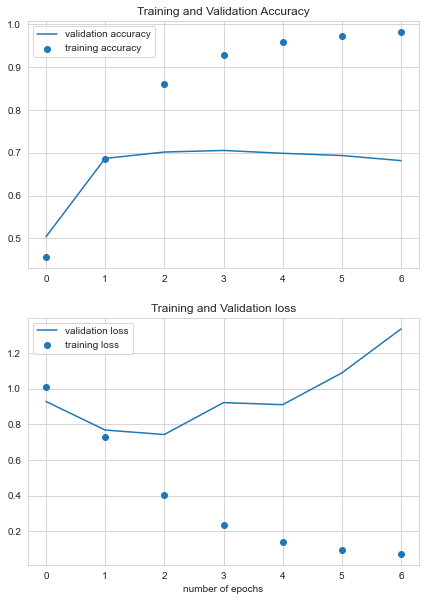

In [643]:
display_training_curves(history5)